In [58]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Dataset: Breast Cancer
<li> Breast cancer is a malignant (cancer) tumor that starts in the cells of the breast. It is found mostly in women, but men can get breast cancer, too.
<li> The data set will be looking at the size of tumors and build a model to predict malignant or non-malignant (benign) tumors

In [59]:
data = pd.read_csv("breast_cancer.csv")

In [60]:
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


<li>Looks like we can drop both the Unnamed and id number.
<li>Neither appears to be an independent variable 

In [61]:
data = data.drop(['Unnamed: 0','id number'], axis=1)

In [62]:
#Seperate dependent variable from independent variables
y = data.pop("malignant")

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

In [32]:
### Grid Search
n_estimators = [100, 200, 500, 1000, 2000]
max_features = ['auto', 'sqrt','log2', 0.2, 0.9]
min_samples_split = [3,5,7,9]


rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)

In [63]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [3, 5, 7, 9], 'max_features': ['auto', 'sqrt', 'log2', 0.2, 0.9], 'n_estimators': [100, 200, 500, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [64]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.2, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
best_rfc = estimator.best_estimator_

### Accuracy

In [35]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print"Accuracy:", accuracy

Accuracy: 0.978571428571


### Precision and Recall

In [66]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.99      0.98      0.98        95
          1       0.96      0.98      0.97        45

avg / total       0.98      0.98      0.98       140



<li>Precision: The model will idenitfy correctly identify 98% of the total population and of the malignant tumor population 96% will be correctly identified. This means there is a 4% chance there will be a false positive.  
<li>Recall: Of the 96 percent of people indentified as have a malignant tumore 98% of them will actually have a malignant tumor.

In [67]:
print confusion_matrix(y_test, best_rfc.predict(X_test))

[[93  2]
 [ 1 44]]


<l> Precsion: 44/(44+2) = 95.65
<l> Recall : 44/(44+1) = 97.77

### AUC

In [72]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.997192982456


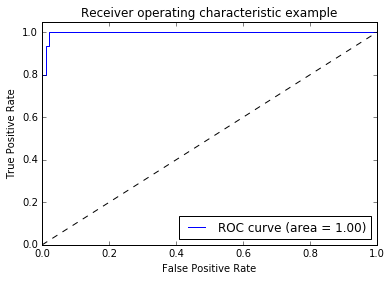

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [74]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)

In [76]:
scores

array([ 0.92957746,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  1.        ,  0.98571429,  0.98550725,  0.98550725])

In [79]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.971488 +/-  0.018710
95 percent probability that if this experiment were repeated over and over the average score would be between 0.952778 and 0.990198


### K-Fold CV vs Single Holdout

<li>K-Fold gave us an AUC of 0.971488 +/-  0.016212 with a 95% confindece interval 
<li>This is significant because our AUC for Single Holdout was more than a standard above this value at 0.997192982456
<li>This is a clear indicator that we were over fitting the data
<li>With a larger dataset we would want to consider a train, validate, test split

### Breast Cancer Random Forest Model

<li> Precision: The model will idenitfy correctly identify 98% of the total population and of the malignant tumor population 96% will be correctly identified. This means there is a 4% chance there will be a false positive.
<li> Recall: Of the 96 percent of people indentified as have a malignant tumore 98% of them will actually have a malignant tumor.

<li> Accuracy: The overall accuracy was 97.85 % which is pretty high but this partially be to having a large number of benign tumors.

<li> AUC Score:  0.997192982456 this is almost a perfect score which means we mostly overfit the data by using hyperparameters